In [ ]:
!pip install sentence-transformers torch==1.13.1 --force-reinstall

In [2]:
import pandas as pd
import numpy as np
import spacy
from sentence_transformers import SentenceTransformer

/home/qnbhd/anaconda3/envs/cleanenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [4]:
nlp = spacy.load("en_core_web_sm")

In [5]:
train['comment'] = train['comment'].apply(
    lambda x: ' '.join([
        tok.lemma_.lower() for tok in nlp(x)
        if not tok.is_punct
        # and not tok.like_num
        # and not tok.like_email
        # and not tok.is_stop
    ])
)

In [6]:
test['comment'] = test['comment'].apply(
    lambda x: ' '.join([
        tok.lemma_.lower() for tok in nlp(x)
        if not tok.is_punct
    ])
)

In [7]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [8]:
X_train_embeddings = model.encode(train['comment'].values, show_progress_bar=True)

Batches: 100%|████████████████████████████| 25/25 [00:00<00:00, 32.26it/s]


In [79]:
import umap
import umap.plot

In [80]:
mapper = umap.UMAP(n_neighbors=200).fit(X_train_embeddings)

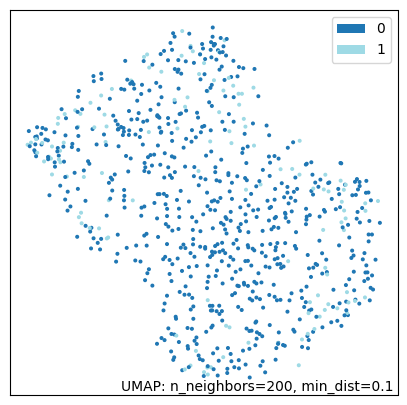

In [81]:
fig = umap.plot.points(mapper, labels=train['isHate'], color_key_cmap='tab20', width=500, height=500)

In [9]:
X_test_embeddings = model.encode(test['comment'].values, show_progress_bar=True)

Batches: 100%|█████████████████████████████| 7/7 [00:00<00:00, 113.74it/s]


In [10]:
from lazypredict.Supervised import LazyClassifier

In [11]:
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

In [12]:
models, predictions = clf.fit(X_train_embeddings, X_test_embeddings, train['isHate'], test['isHate'])

 38%|██████████████                       | 11/29 [00:04<00:04,  4.15it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|█████████████████████████████████████| 29/29 [00:07<00:00,  3.76it/s]


In [13]:
models.sort_values(by='ROC AUC', ascending=False)

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NearestCentroid,0.69,0.70,0.70,0.72,0.07
LinearDiscriminantAnalysis,0.79,0.70,0.70,0.80,0.22
RidgeClassifierCV,0.84,0.69,0.69,0.84,0.12
LogisticRegression,0.78,0.67,0.67,0.79,0.05
RidgeClassifier,0.81,0.67,0.67,0.82,0.05
GaussianNB,0.74,0.66,0.66,0.76,0.03
LinearSVC,0.76,0.66,0.66,0.78,0.22
PassiveAggressiveClassifier,0.74,0.65,0.65,0.77,0.07
BernoulliNB,0.76,0.65,0.65,0.78,0.03


In [47]:
from sklearn.linear_model import RidgeClassifierCV, LogisticRegression
from sklearn.neighbors import NearestCentroid, KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

In [51]:
clf = NearestCentroid().fit(X_train_embeddings, train['isHate'])

In [52]:
print(classification_report(test['isHate'], clf.predict(X_test_embeddings)))

              precision    recall  f1-score   support

           0       0.93      0.68      0.78       167
           1       0.31      0.73      0.43        33

    accuracy                           0.69       200
   macro avg       0.62      0.70      0.61       200
weighted avg       0.82      0.69      0.72       200



In [53]:
roc_auc_score(test['isHate'], clf.predict(X_test_embeddings))

0.7019597169297768